In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_validate, RepeatedKFold, learning_curve
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn import metrics
import matplotlib.ticker as mtick
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [88]:
data = pd.read_csv('../data/employee_churn_processed.csv')

# Model selection

## Data Preprocessing

We are only concerned with high performers so we will focus on employees with performance ratings of 4 and 5.

In [89]:
data = data[(data['PerformanceRating'] == 4) | (data['PerformanceRating'] == 5)]

Dropping complaint features due to nulls (and no obvious relevance from analysis).

In [90]:
data = data.drop(columns = ['complaintresolved', 'complaintyears', 'complaintfiled'])

Applying data types again.

In [91]:
data = data.astype({'Age' : 'int32', 'Department': 'int32', 'NumCompaniesWorked':'int32',
                    'workingfromhome':'int32','DistanceFromHome':'int32', 'JobSatisfaction':'int32', 
                    'PercentSalaryHike':'int32','PerformanceRating':'int32','TotalWorkingYears':'int32', 
                    'YearsAtCompany':'int32','YearsSinceLastPromotion':'int32', 'gender_label':'int32', 
                    'businesstravel_label':'int32','monthlyincome_label':'int32', 'left_label':'int32' })

## Feature Selection

In [115]:
data2 = data.copy()

### Check correlation

<AxesSubplot:>

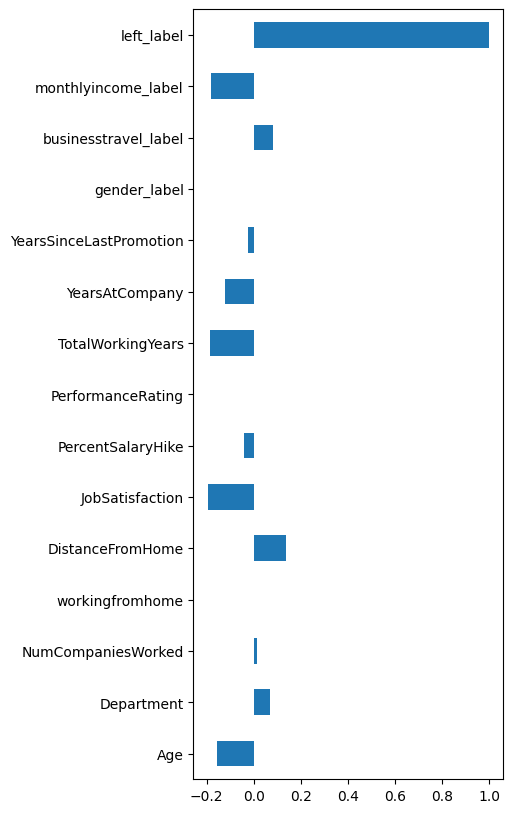

In [116]:
(data2.corr().loc['left_label']
 .plot(kind='barh', figsize=(4,10)))

Remove Gender, Performance Rating, Working from home

In [128]:
data2 = data2.drop(columns = ['gender_label','PerformanceRating','workingfromhome'])

### Check colinearity

In [129]:
y = data2['left_label']
X = data2.drop(columns = ['left_label'])

vifdf = pd.DataFrame()
vifdf['vif_index'] = [vif(X.values, i) for i in range(X.shape[1])]
vifdf['features'] = X.columns
vifdf

,vif_index,features
0,25.356841,Age
1,6.814799,Department
2,2.741964,NumCompaniesWorked
3,2.294607,DistanceFromHome
4,7.026641,JobSatisfaction
5,23.032772,PercentSalaryHike
6,10.419570,TotalWorkingYears
7,5.498975,YearsAtCompany
8,2.227960,YearsSinceLastPromotion
9,4.947955,businesstravel_label


Removing 'PercentSalaryHike' and 'Age' due to feature correlation

In [130]:
X = X.drop(columns = ['PercentSalaryHike', 'Age'])
vifdf = pd.DataFrame()
vifdf['vif_index'] = [vif(X.values, i) for i in range(X.shape[1])]
vifdf['features'] = X.columns
vifdf

,vif_index,features
0,5.316739,Department
1,2.507359,NumCompaniesWorked
2,2.187610,DistanceFromHome
3,5.249192,JobSatisfaction
4,7.743718,TotalWorkingYears
5,5.426123,YearsAtCompany
6,2.217831,YearsSinceLastPromotion
7,3.955819,businesstravel_label
8,4.539909,monthlyincome_label


Correlation within acceptable bounds

### Low Variance Features

#### Numerical Features

In [133]:
X.columns

Index(['Department', 'NumCompaniesWorked', 'DistanceFromHome',
       'JobSatisfaction', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'businesstravel_label',
       'monthlyincome_label'],
      dtype='object')

In [135]:
# variance of numeric features
(X[['NumCompaniesWorked', 'DistanceFromHome',
       'JobSatisfaction', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsSinceLastPromotion']]
 .select_dtypes(include=np.number)
 .var()
 .astype('str'))

NumCompaniesWorked         6.1943223157095995
DistanceFromHome            69.98023374323952
JobSatisfaction            1.2048415054195403
TotalWorkingYears          59.105727527692856
YearsAtCompany              33.06527997857478
YearsSinceLastPromotion     9.426607449728838
dtype: object

#### Categorical Features

In [136]:
X_cat = X[['Department','businesstravel_label','monthlyincome_label']]

In [141]:
crosstab1 = pd.crosstab(X_cat['Department'], X_cat['businesstravel_label'])

In [142]:
chi2_contingency(crosstab1)

(3.702332971192294,
 0.4477866973832504,
 4,
 array([[ 35.23121387, 244.62427746,  65.14450867],
        [ 15.72639692, 109.19460501,  29.07899807],
        [  2.04238921,  14.18111753,   3.77649326]]))

In [144]:
crosstab2 = pd.crosstab(X_cat['Department'], X_cat['monthlyincome_label'])

In [146]:
chi2_contingency(crosstab2)

(19.719212103121222,
 0.0005673376023101636,
 4,
 array([[114.33526012, 144.9132948 ,  85.75144509],
        [ 51.03660886,  64.68593449,  38.27745665],
        [  6.62813102,   8.40077071,   4.97109827]]))

In [147]:
crosstab3 = pd.crosstab(X_cat['businesstravel_label'], X_cat['monthlyincome_label'])

In [148]:
chi2_contingency(crosstab3)

(1.1579442777580014,
 0.8849730835100711,
 4,
 array([[ 17.56454721,  22.26204239,  13.1734104 ],
        [121.95761079, 154.57418112,  91.46820809],
        [ 32.477842  ,  41.16377649,  24.3583815 ]]))

Removing Business Travel due to colinearity.

In [149]:
X = X.drop(columns = 'businesstravel_label')

## Test Train split

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Feature Scaling

In [153]:
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled  = min_max_scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train.columns)

In [157]:
# Instantiate model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
coeffs  = model.coef_

<AxesSubplot:>

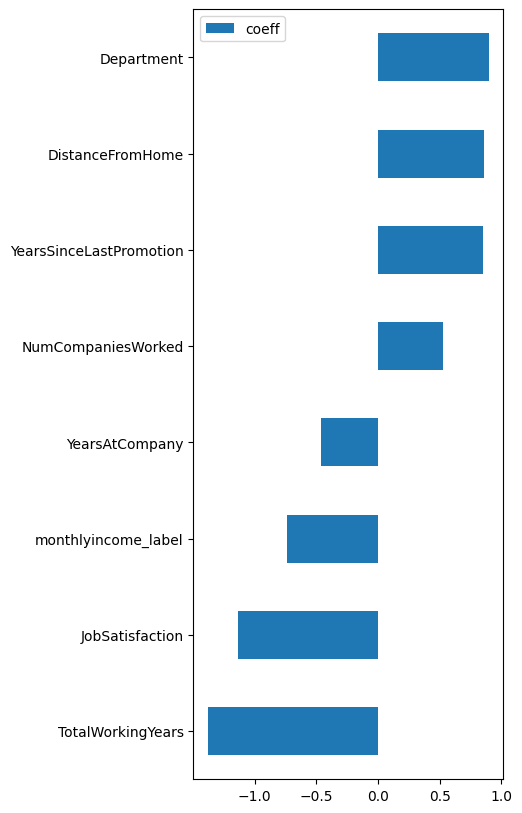

In [167]:
index = X_train_scaled.columns.tolist()
(pd.DataFrame(coeffs.T, index = index, columns = ['coeff']).sort_values(by = 'coeff')
 .plot(kind='barh', figsize=(4,10)))

In [201]:
# 5-Fold Cross validate model
cv_results = cross_validate(model, X_test_scaled, y_test, cv=5)

# Scores
cv_results['test_score']

# Mean of scores
cv_results['test_score'].mean()

0.8207661290322582

## Checking for over/ under fitting

In [222]:
X_scaled = min_max_scaler.transform(X[X_train_scaled.columns.to_list()])
X_scaled = pd.DataFrame(X_scaled, columns = X_train_scaled.columns)

In [227]:
X_scaled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Department               519 non-null    float64
 1   NumCompaniesWorked       519 non-null    float64
 2   DistanceFromHome         519 non-null    float64
 3   JobSatisfaction          519 non-null    float64
 4   TotalWorkingYears        519 non-null    float64
 5   YearsAtCompany           519 non-null    float64
 6   YearsSinceLastPromotion  519 non-null    float64
 7   monthlyincome_label      519 non-null    float64
dtypes: float64(8)
memory usage: 32.6 KB


In [250]:
train_sizes = [i + 1 for i in range(410)]

In [256]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model, X=X_scaled, y=y, train_sizes = train_sizes, cv=5, 
    scoring = 'accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

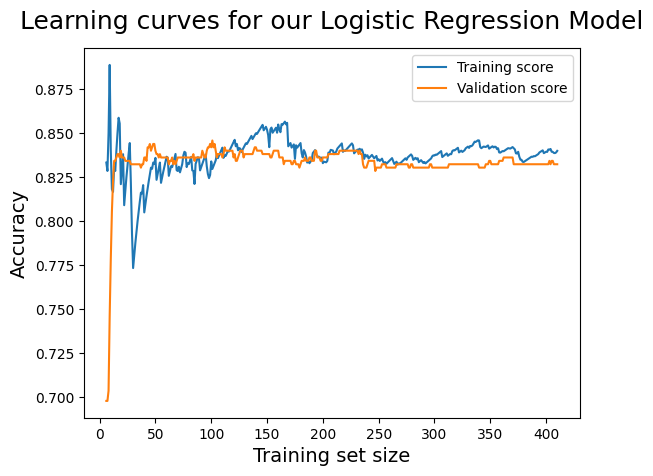

In [259]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation score')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for our Logistic Regression Model', fontsize = 18, y = 1.03)
plt.legend();

## Model predictions

In [260]:
model2 = LogisticRegression()
model2.fit(X_train_scaled,y_train)
pred_test = model2.predict_proba(X_test_scaled)
print(model2.coef_)

[[ 0.90206687  0.52510297  0.85615532 -1.13636755 -1.38210376 -0.46397942
   0.85415591 -0.73497756]]


In [261]:
feature_coeff_dict = {}
for i in range(len(X_train_scaled.columns)):
    feature_coeff_dict[X_train_scaled.columns[i]] = model2.coef_[0][i]

In [262]:
feature_coeff_dict

{'Department': 0.9020668681447396,
 'NumCompaniesWorked': 0.5251029719372275,
 'DistanceFromHome': 0.8561553232507815,
 'JobSatisfaction': -1.1363675539837408,
 'TotalWorkingYears': -1.382103760653468,
 'YearsAtCompany': -0.46397941621024386,
 'YearsSinceLastPromotion': 0.8541559104393273,
 'monthlyincome_label': -0.7349775630317522}

In [263]:
pred_test_df = pd.DataFrame(pred_test)

In [264]:
y_pred_1 = pred_test_df.iloc[:,1]
y_test_df = pd.DataFrame(y_test)
pd.DataFrame(y_test)

,left_label
1145,0
981,0
36,0
839,1
366,0
...,...
1127,0
670,0
287,0
1451,0


In [265]:
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [316]:
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

In [317]:
y_pred_final['left_label'].value_counts()

0    127
1     29
Name: left_label, dtype: int64

In [318]:
y_pred_final = y_pred_final.rename(columns = { 1 : "Yes_Prob"})

## Probability Threshold Analysis

In [319]:
numbers = [ round((x/100 + 0.1),2) for x in range(11)]
for i in numbers:
    y_pred_final[i]= y_pred_final['Yes_Prob'].map(lambda x: 1 if x > i else 0)

In [320]:
y_pred_final

,left_label,Yes_Prob,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2
0,0,0.178756,1,1,1,1,1,1,1,1,0,0,0
1,0,0.130432,1,1,1,1,0,0,0,0,0,0,0
2,0,0.247981,1,1,1,1,1,1,1,1,1,1,1
3,1,0.361230,1,1,1,1,1,1,1,1,1,1,1
4,0,0.046527,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,0.096543,0,0,0,0,0,0,0,0,0,0,0
152,0,0.096762,0,0,0,0,0,0,0,0,0,0,0
153,0,0.109023,1,0,0,0,0,0,0,0,0,0,0
154,0,0.054781,0,0,0,0,0,0,0,0,0,0,0


In [321]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model2, X_test_scaled, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

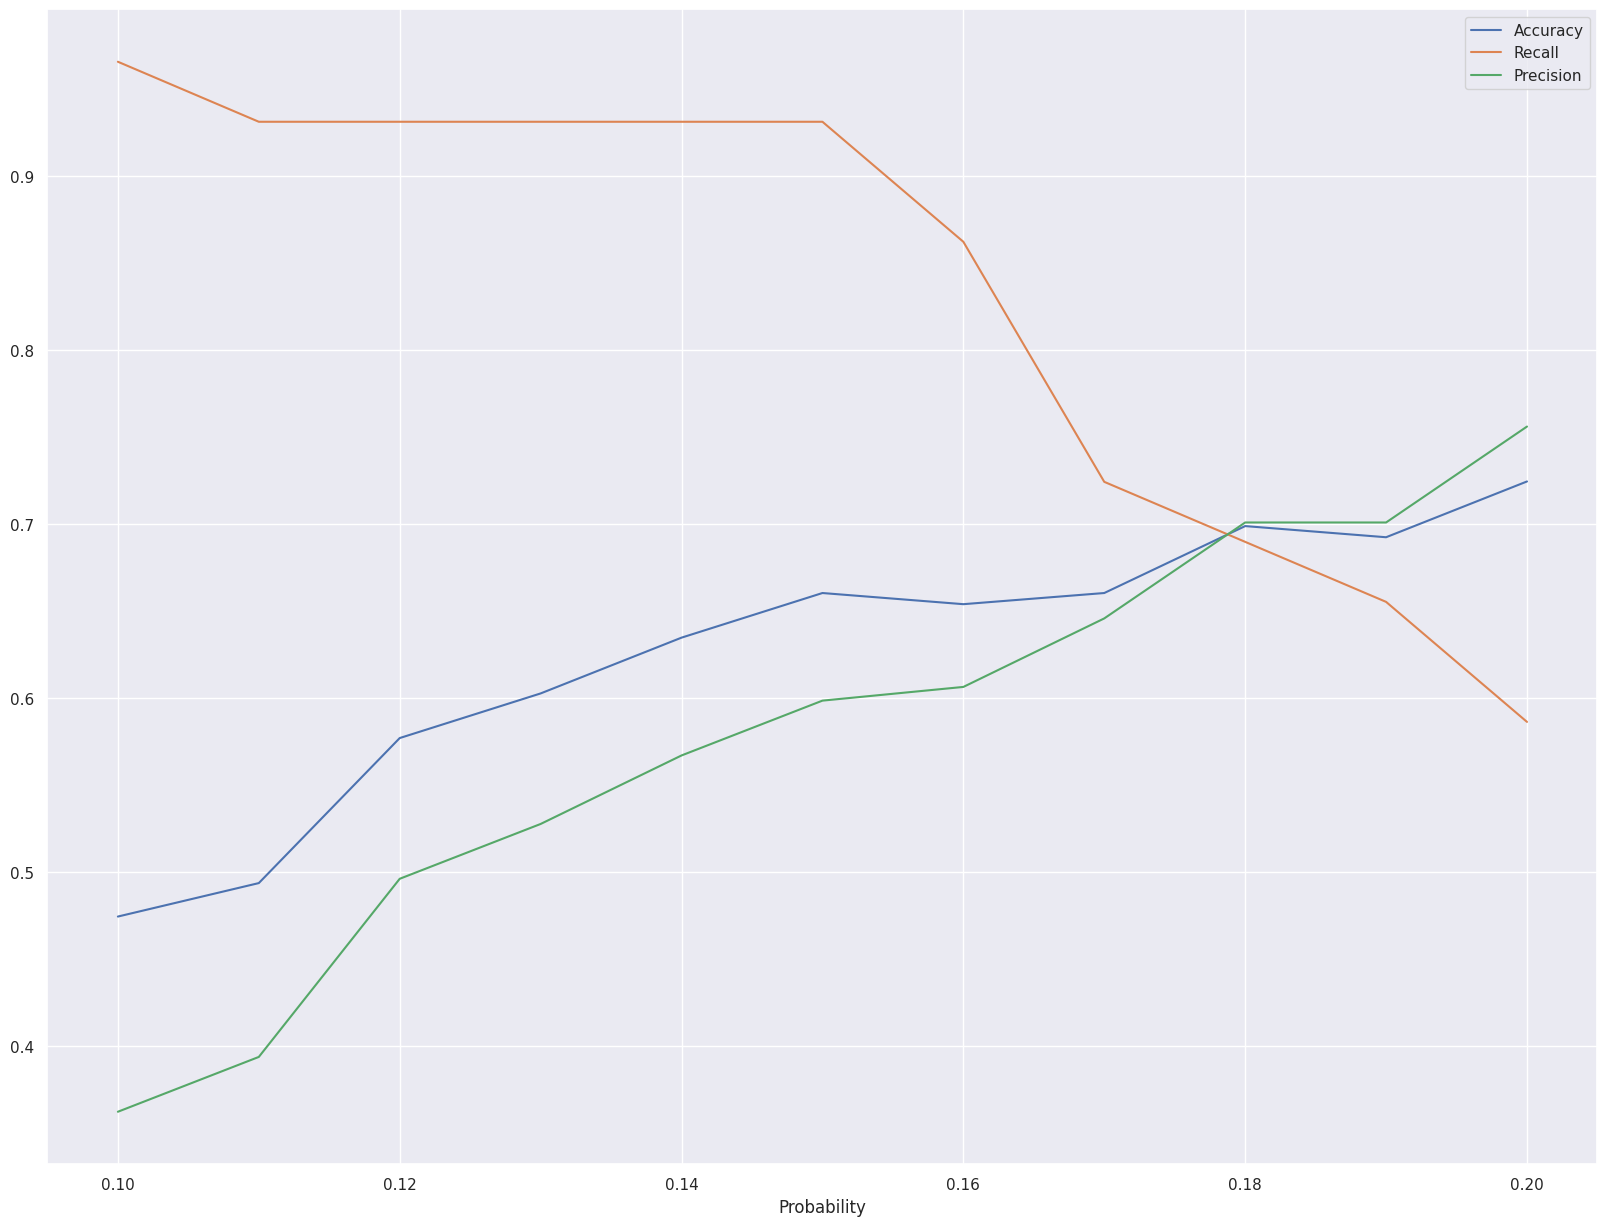

In [322]:
Probability = pd.DataFrame( columns = ['Probability', 'Accuracy', 'Recall', 'Precision'])
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,15)})
for i in numbers:
    CM = metrics.confusion_matrix(y_pred_final['left_label'],y_pred_final[i] )
    Total = sum(sum(CM))
    Accuracy    = (CM[0,0]+CM[1,1])/Total
    Recall = CM[1,1]/(CM[1,1]+CM[1,0])
    Precision = CM[0,0]/(CM[0,0]+CM[0,1])
    Probability.loc[i] =[ i, Accuracy, Recall, Precision]
Probability.plot.line(x='Probability', y=['Accuracy','Recall','Precision']);

In [299]:
y_pred_final

,left_label,Yes_Prob,0.1,0.11,0.12000000000000001,0.13,0.14,0.15000000000000002,0.16,0.17,0.18,0.19,0.2
0,0,0.178756,1,1,1,1,1,1,1,1,0,0,0
1,0,0.130432,1,1,1,1,0,0,0,0,0,0,0
2,0,0.247981,1,1,1,1,1,1,1,1,1,1,1
3,1,0.361230,1,1,1,1,1,1,1,1,1,1,1
4,0,0.046527,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,0.096543,0,0,0,0,0,0,0,0,0,0,0
152,0,0.096762,0,0,0,0,0,0,0,0,0,0,0
153,0,0.109023,1,0,0,0,0,0,0,0,0,0,0
154,0,0.054781,0,0,0,0,0,0,0,0,0,0,0


In [323]:
pred_test = model2.predict_proba(X_test_scaled)
y_pred_final_thresh = y_pred_final[['left_label','Yes_Prob',0.18]]
y_pred_final_thresh_2 = y_pred_final[['left_label','Yes_Prob',0.15]]

In [325]:
y_pred_final_thresh_2[y_pred_final_thresh_2[0.15] == 1]

,left_label,Yes_Prob,0.15
0,0,0.178756,1
2,0,0.247981,1
3,1,0.361230,1
17,0,0.195929,1
20,1,0.162063,1
...,...,...,...
143,1,0.178330,1
147,1,0.250783,1
148,0,0.174446,1
150,0,0.209543,1


## Confusion Matrix

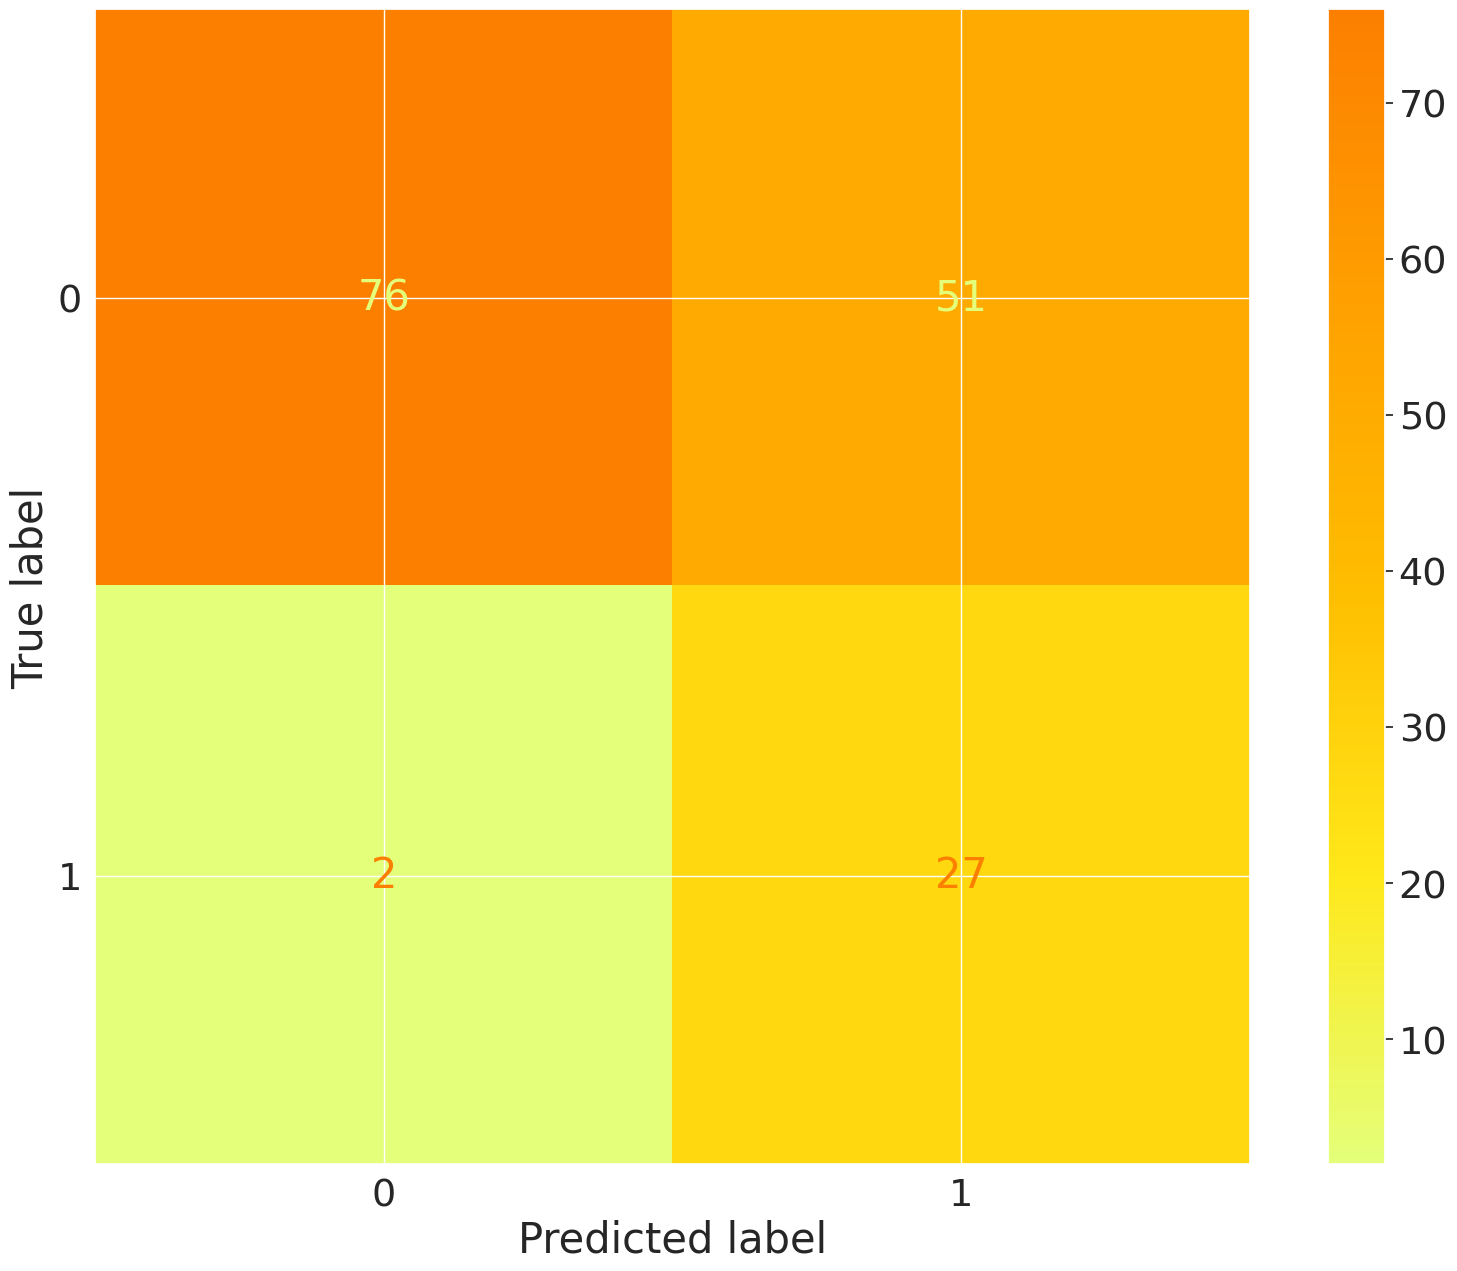

In [337]:
sns.set(font_scale=2.5)
c_m = confusion_matrix(y_pred_final_thresh_2['left_label'], y_pred_final_thresh_2[0.15])

ConfusionMatrixDisplay(c_m)

disp = ConfusionMatrixDisplay.from_predictions(y_pred_final_thresh_2['left_label'],y_pred_final_thresh_2[0.15], cmap = 'Wistia')
    
# disp.ax_.set_title(title)

print(disp);


In [333]:
y_pred_final_thresh_2[y_pred_final_thresh_2['left_label'] == 1].shape

(29, 3)

In [334]:
76/78

0.9743589743589743

for recall this is 76/78 = 97%
for accuracy this is 103/172 = 54% of users who were judged 'at risk' haven't left - ideal quantity 

In [ ]:
accuracy = TP + TN /  Total
Precision = TP / (TP + FP)

In [364]:
Total = c_m[0,0] + c_m[0,1] + c_m[1,0] +c_m[1,1]
Accuracy = (c_m[0,0]+c_m[1,1])/Total
Precision = c_m[1,1]/(c_m[1,1]+CM[0,1])
Recall = c_m[1,1]/(c_m[1,1]+c_m[1,0])
F1 = 2*(Recall*Precision)/(Recall+Precision)

In [365]:
print(Accuracy,Recall,Precision,F1)

0.6602564102564102 0.9310344827586207 0.46551724137931033 0.6206896551724138


We have achieved 93% recall with only a slightly drop in our optimum accuracy. A low precision isn't ideal but it's much more valuable to misidentify someone as a leaver than misidentify them as someone who will stay. Once someone has left the company it is very unlikely they will return. 

We can also use the False Positive group to focus on as 'at risk' employees - more attention can be given to them to convince them to remain with the company.